<a href="https://colab.research.google.com/github/ScarrryMary/IT_MIPT_group25-26/blob/main/2_semester/Seminar2_3_25_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

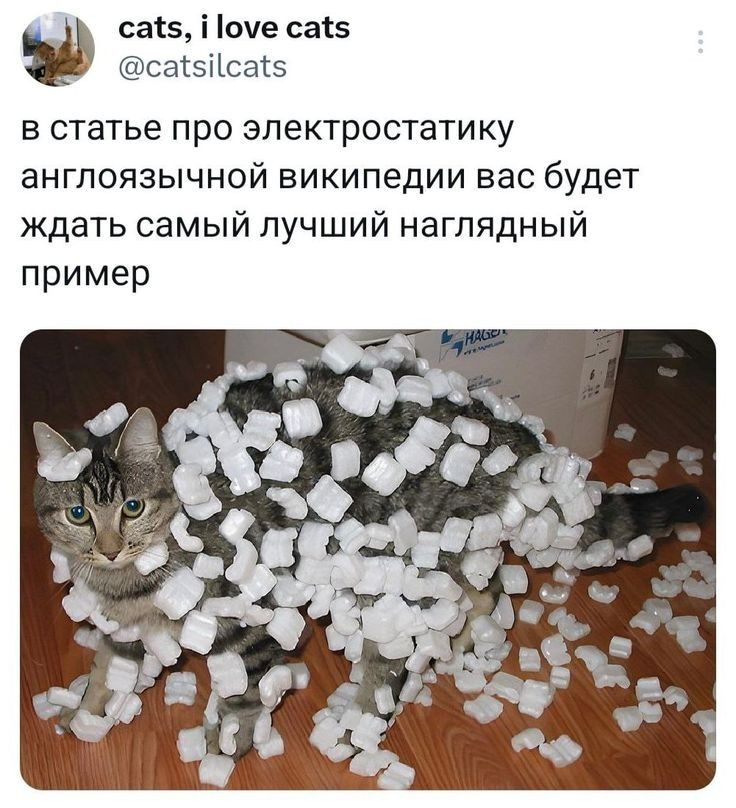

# Поиск компонент сильной связности (SCC)
**Определение**: Две вершины ориентированного графа связаны сильно (англ. strongly connected), если существует путь из одной в другую и наоборот. Иными словами, они обе лежат в каком-то цикле.

Компоненты сильной связности (SCC) — это максимальные подмножества вершин ориентированного графа, в которых каждая вершина достижима из каждой (есть путь в обе стороны)

Понятно, что такое отношение транзитивно: если a и b сильно связны, и b и c сильно связны, то a и c тоже сильно связны. Поэтому все вершины распадаются на компоненты сильной связности — такое разбиение вершин, что внутри одной компоненты все вершины сильно связаны, а между вершинами разных компонент сильной связности нет.

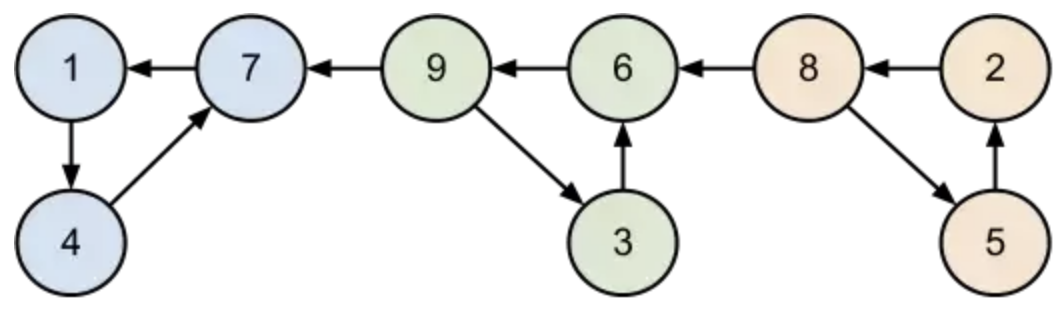

Часто рассматривают граф, составленный из самих компонент сильной связности, а не индивидуальных вершин. Очевидно, такой граф уже будет ациклическим, и с ним проще работать. **Задачу о сжатии каждой компоненты сильной связности в одну вершину называют конденсацией графа**.



# Алгоритм Тарьяна

Универсальный **DFS**-алгоритм для поиска компонент сильной связности (SCC) в ориентированном графе за линейное время $O(V+E)$. Создан Робертом Тарьяном в 1972 году!

Что нам важно?
```python
disc[u] = момент первого посещения u (порядковый номер)
low[u] = "самый ранний" предок, достижимый из поддерева u
стек = текущий путь DFS (активные вершины)
```

Алгоритм:
```python
1. disc[u] = low[u] = time++
2. PUSH u в стек
3. Для каждого соседа v:
   if v не посещена:        # Tree edge
     DFS(v)
     low[u] = min(low[u], low[v])
   elif v в стеке:          # Back edge
     low[u] = min(low[u], disc[v])
4. if low[u] == disc[u]:   # Корень SCC!
   POP из стека до u → SCC готова
```
```
low[u] собирает "ранние" предки из:
1. disc[u] — сама вершина
2. low[v] — из поддеревьев  
3. disc[w] — **BACK EDGES** в стеке!

low[u] == disc[u] → нет back edges "наверх" → SCC!
```

Обратное ребро — это ребро из текущей вершины $u$ в предка $v$, который уже в стеке DFS (т.е. disc[v] < disc[u] и v активен).

```python
Время | Стек | Ребро | Тип
0    | [0]  | 0→1  | Tree edge
1    | [0,1]| 1→3  | Tree edge  
2    | [0,1,3] | ↑ | ↑
3    | [0,1] | 0→2 | Tree edge
4    | [0,1,2] | 2→1 | **BACK EDGE!** (1 в стеке)
5    | [0,1,2,4] | 4→1 | **BACK EDGE!** (1 в стеке)
```



In [4]:
def tarjan(graph):
    n = len(graph)
    disc = [-1] * n
    low = [-1] * n
    stack = []
    in_stack = [False] * n
    time = 0
    scc = []

    def dfs(u):
        nonlocal time
        disc[u] = low[u] = time
        time += 1
        stack.append(u)
        in_stack[u] = True

        for v in graph[u]:
            if disc[v] == -1:  # Tree edge
                dfs(v)
                low[u] = min(low[u], low[v])
            elif in_stack[v]:  # Back edge
                low[u] = min(low[u], disc[v])

        # Корень SCC
        if low[u] == disc[u]:
            component = []
            while True:
                v = stack.pop()
                in_stack[v] = False
                component.append(v)
                if v == u:
                    break
            scc.append(component)

    for i in range(n):
        if disc[i] == -1:
            dfs(i)

    return scc

# Тест
graph1 = [[1,2], [3], [1], [], [2, 1]]
print(tarjan(graph1))
graph2 = [[3], [7], [5], [6], [1], [8], [0], [5, 4], [6, 2]]
print(tarjan(graph2))
graph3 = [[1], [2], [0, 3], [4], [5, 7], [6], [0, 2, 5], [3, 5, 8], [4, 7]]
print(tarjan(graph3))

[[3], [1], [2], [0], [4]]
[[6, 3, 0], [2, 8, 5], [4, 7, 1]]
[[8, 7, 6, 5, 4, 3, 2, 1, 0]]


# Алгоритм Косарайю

Алгоритм Косарайю находит компоненты сильной связности в ориентированном графе за $O(V+E)$ с помощью **двух DFS**: один на исходном графе, второй на транспонированном.

Алгоритм:
1. Выполнение поиска в глубину (DFS) на исходном графе:
* Сначала мы проводим DFS на исходном графе и записываем время завершения узлов (то есть время, когда DFS полностью исследует узел).

2. Выполнение DFS на транспонированном графе:
* Затем мы меняем направление всех рёбер графа, чтобы создать транспозиционированный граф.
* Далее мы проводим DFS на транспонированном графе, рассматривая узлы в убывающем порядке их финишных времен, зафиксированных на первой фазе.
* Каждое прохождение DFS в этой фазе даст нам один SCC.

In [8]:
def kosaraju(graph):
    n = len(graph)

    # 1. DFS на исходном графе → порядок завершения
    visited = [False] * n
    order = []

    def dfs1(u):
        visited[u] = True
        for v in graph[u]:
            if not visited[v]:
                dfs1(v)
        order.append(u)  # Добавляем ПОСЛЕ обработки соседей

    for i in range(n):
        if not visited[i]:
            dfs1(i)

    order.reverse()  # Порядок ФИНИШНОГО времени

    # 2. Транспонированный граф
    transpose = [[] for _ in range(n)]
    for u in range(n):
        for v in graph[u]:
            transpose[v].append(u)
    print(f'transpose: {transpose}')

    # 3. DFS на транспонированном в порядке order
    visited = [False] * n
    scc = []

    def dfs2(u, component):
        visited[u] = True
        component.append(u)
        for v in transpose[u]:
            if not visited[v]:
                dfs2(v, component)

    for u in order:
        if not visited[u]:
            component = []
            dfs2(u, component)
            scc.append(component)

    return scc

# Тест
graph1 = [[1,2], [3], [1], [], [2, 1]]
print(kosaraju(graph1))
graph2 = [[3], [7], [5], [6], [1], [8], [0], [5, 4], [6, 2]]
print(kosaraju(graph2))
graph3 = [[1], [2], [0, 3], [4], [5, 7], [6], [0, 2, 5], [3, 5, 8], [4, 7]]
print(kosaraju(graph3))



transpose: [[], [0, 2, 4], [0, 4], [1], []]
[[4], [0], [2], [1], [3]]
transpose: [[6], [4], [8], [0], [7], [2, 7], [3, 8], [1], [5]]
[[1, 4, 7], [5, 2, 8], [0, 6, 3]]
transpose: [[2, 6], [0], [1, 6], [2, 7], [3, 8], [4, 6, 7], [5], [4, 8], [7]]
[[0, 2, 1, 6, 5, 4, 3, 7, 8]]


Первый DFS даёт порядок завершения (finish times), который ранжирует вершины по "глубине" достижимости. Второй DFS на транспонированном графе группирует вершины в SCC по этому рангу.

# Минимальное остовное дерево (MST)

Рассмотрим следующую задачу:

Авиакомпания содержит $m$ рейсов между $n$ городами, $i$-ый из них обходится в $w_i$ рублей, причём из любого города можно добраться до любого другого. В стране наступил кризис, и нужно отказаться от как можно большего числа из них таким образом, что содержание оставшихся рейсов будет наиболее дешевым.

Иными словами, нужно найти дерево минимального веса, которое является подграфом данного неориентированного графа. Почему дерево? Потому что в противном случае там был бы цикл, из которого можно удалить какое-то ребро и получить более оптимальный ответ. А если это больше, чем одно дерево, то какие-то две вершины остаются несвязны.

Такие деревья называют остовами (каркас, скелет; ударение на первый слог, но так мало кто произносит; англ. minimum spanning tree — дословно, минимальное покрывающее дерево).

* Если остовный подграф является деревом (связным графом без циклов), то он называется остовным деревом, а если еще и имеет наименьшую сумму весов ребер среди всех остовных деревьев, то называется минимальным остовным деревом.

* Разрезом графа называется разбиение вершин графа на два непересекающихся множества. ИЛИ: Разрезом связного графа будем называть подмножество рёбер и вершин, образующих подграф, в котором есть ровно две компоненты связности.
* Ребро пересекает данный разрез, если при его добавлении граф снова становится связным.

* Ребро $(v,u)$ пересекает разрез $(S,U)$, если $v ∈ S, u ∈ U$.

Все алгоритмы для поиска минимального остова опираются на следующее утверждение:



## **Лемма о безопасном ребре**
Рассмотрим произвольный разрез какого-либо подграфа минимального остова. Тогда ребро минимального веса, пересекающее этот разрез, является безопасным.

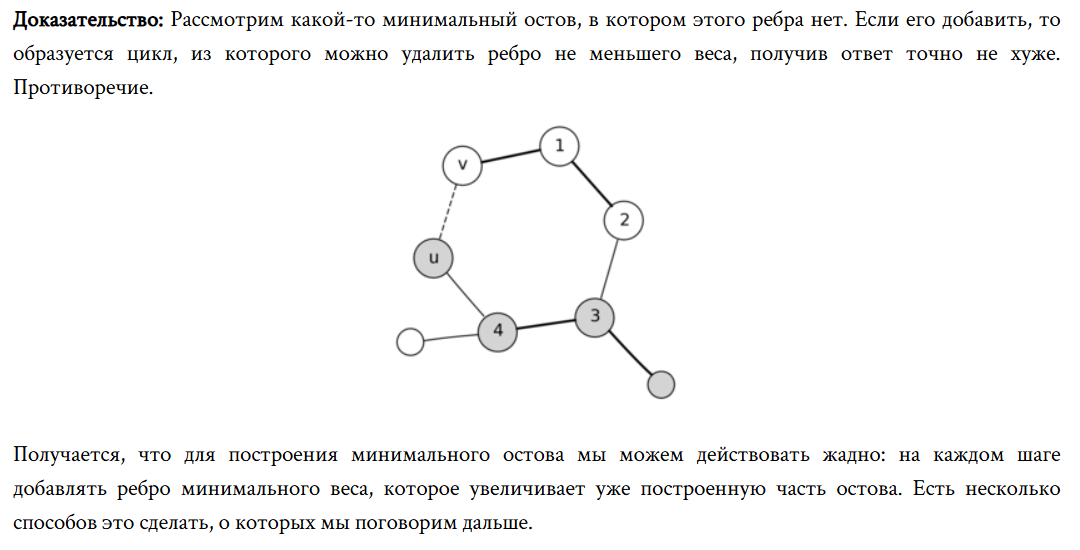

## Алгоритм Прима

Лемма о безопасном ребре говорит, что мы можем строить минимальный остов постепенно, добавляя по одному ребра, про которые мы точно знаем, что они минимальные для соединения какого-то разреза.

Один из подходов это использовать заключается в алгоритме Прима:

* Изначально остов — одна произвольная вершина.
* Пока минимальный остов не найден, выбирается ребро минимального веса, исходящее из какой-нибудь вершины текущего остова в вершину, которую мы ещё не добавили. Добавляем это ребро в остов и начинаем заново, пока остов не будет найден.


Этот алгоритм очень похож на алгоритм Дейкстры, только мы выбираем следующую вершину с другой весовой функцией — вес минимального соединяющего ребра вместо суммарного расстояния до неё.

In [9]:
import heapq

def prim(graph, n):
    """
    Алгоритм Прима для MST
    graph: [[(v, w), ...], ...] - списки смежности
    """
    INF = float('inf')
    min_edge = [INF] * n          # min вес до дерева
    used = [False] * n            # в MST?
    parent = [-1] * n             # для восстановления пути
    min_edge[0] = 0               # старт с вершины 0

    pq = [(0, 0)]                 # (вес, вершина)

    mst_weight = 0

    while pq:
        weight, u = heapq.heappop(pq)
        if used[u] or weight > min_edge[u]:
            continue

        used[u] = True
        mst_weight += weight

        for v, w in graph[u]:
            if not used[v] and w < min_edge[v]:
                min_edge[v] = w
                parent[v] = u
                heapq.heappush(pq, (w, v))

    return mst_weight, parent

# Тестовый граф
graph = [
    [(2,1), (1,3)],      # 0
    [(0,3), (3,5)],      # 1
    [(0,1), (4,2), (5,3)], # 2
    [(1,5)],             # 3
    [(2,2), (6,1)],      # 4
    [(2,3)],             # 5
    [(4,1)]              # 6
]

weight, tree = prim(graph, 7)
print(f"MST вес: {weight}")  # 15
print("Дерево:", tree)       # [-1, 0, 0, 1, 2, 2, 4]

MST вес: 15
Дерево: [-1, 0, 0, 1, 2, 2, 4]


```python
Итерация | Дерево | Добавили | Вес
0        | {0}    | 0→2      | 1
1        | {0,2}  | 2→4      | 2
2        | {0,2,4}| 4→6      | 1
3        | {0,2,4,6} | 0→1   | 3
4        | {0,1,2,4,6} | 1→3 | 5
5        | {0,1,2,3,4,6} | 2→5 | 3
ИТОГО    | {0-6}  |          | **15**
```

```python
Значение | Вершина | Родитель | Ребро MST
---------|---------|----------|----------
-1       | **0**   | **корень** | -
0        | **1**   | **0**    | **0→1 (вес 3)**
0        | **2**   | **0**    | **0→2 (вес 1)**
1        | **3**   | **1**    | **1→3 (вес 5)**
2        | **4**   | **2**    | **2→4 (вес 2)**
2        | **5**   | **2**    | **2→5 (вес 3)**
4        | **6**   | **4**    | **4→6 (вес 1)**
```

In [11]:
def prim_simple(graph, n):
    used = [False] * n
    min_edge = [float('inf')] * n
    min_edge[0] = 0

    mst_weight = 0
    edges = []

    for _ in range(n):
        # Найти непосещённую с min весом
        u = -1
        for i in range(n):
            if not used[i] and (u == -1 or min_edge[i] < min_edge[u]):
                u = i

        used[u] = True
        mst_weight += min_edge[u]

        # Обновить соседей
        for v, w in graph[u]:
            if not used[v] and w < min_edge[v]:
                min_edge[v] = w

    return mst_weight


graph = [
    [(2,1), (1,3)],      # 0
    [(0,3), (3,5)],      # 1
    [(0,1), (4,2), (5,3)], # 2
    [(1,5)],             # 3
    [(2,2), (6,1)],      # 4
    [(2,3)],             # 5
    [(4,1)]              # 6
]
weight = prim_simple(graph, 7)
print(f"MST вес: {weight}")

MST вес: 15


Сложность:

* Простая реализация:	$O(V^2)$
* С кучей:	$O((V+E)logV)$

## Алгоритм Краскала

Другой способ использовать лемму о безопасном ребре — отсортировать все ребра и пытаться добавлять их в изначально пустой остов в порядке возрастания их весов.

Если очередное ребро соединяет какие-то две уже соединенные вершины, то проигнорируем его. Иначе оно является безопасным, так как оно минимальное из соединяющих какие-то две различные компоненты, и его можно добавить.

Звучит очень просто: отсортировать все рёбра, пройтись по ним циклом и делать проверку, что вершины в разных компонентах. Но наивная проверка dfs-ом от концов всех ребер будет работать за $O(nm)$. Асимптотику можно улучшить до $O(mlogm)$ — до стоимости сортировки ребер — если для проверок использовать систему непересекающихся множеств.

In [18]:
def kruskal(graph_edges, n):
    """
    graph_edges: list[(w, u, v)]
    """
    # Сортируем рёбра
    graph_edges.sort()
    #print(graph_edges)

    # Изначально каждый = своей компоненте
    component = list(range(n))  # component[i] = группа i

    mst_edges = []
    mst_weight = 0

    def same_component(u, v):
        """В одной компоненте?"""
        return component[u] == component[v]

    def merge_components(u, v):
        """Объединить компоненты"""
        cu, cv = component[u], component[v]
        if cu != cv:
            # Меняем всю группу cv на cu
            for i in range(n):
                if component[i] == cv:
                    component[i] = cu
            return True
        return False

    # Добавляем рёбра по весу
    for w, u, v in graph_edges:
        if not same_component(u, v):  # не цикл?
            if merge_components(u, v):
                mst_edges.append((w, u, v))
                mst_weight += w

    return mst_edges, mst_weight

# Тест
graph_edges = [
    (1, 0, 2), (3, 0, 1), (2, 1, 3), (5, 1, 3),
    (2, 2, 4), (3, 2, 5), (1, 4, 6)
]

n = 7
mst_edges, weight = kruskal(graph_edges, n)
print(f"MST вес: {weight}")
print("Рёбра:", mst_edges)


MST вес: 12
Рёбра: [(1, 0, 2), (1, 4, 6), (2, 1, 3), (2, 2, 4), (3, 0, 1), (3, 2, 5)]


In [19]:
# Маленький граф
edges = [(2,0,1), (3,0,2), (1,1,2)]
print(kruskal(edges, 3))  # вес 3, рёбра [(1,1,2),(2,0,1)]


([(1, 1, 2), (2, 0, 1)], 3)
